### 导入狗数据集

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# 定义函数来加载train，test和validation数据集
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# 加载train，test和validation数据集
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# 加载狗品种列表
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# 打印数据统计描述
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### 导入人脸数据

In [13]:
import random
random.seed(8675309)

# 加载打乱后的人脸数据集的文件名
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# 打印数据集的数据量
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


### 人脸识别器

In [14]:
import cv2                
import matplotlib.pyplot as plt 

# 提取预训练的人脸检测模型
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# 如果img_path路径表示的图像检测到了脸，返回"True" 
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### 狗识别

In [35]:
from keras.applications.resnet50 import ResNet50

# 定义ResNet50模型
ResNet50_model = ResNet50(weights='imagenet')

In [36]:
from keras.applications.resnet50 import preprocess_input, decode_predictions
def ResNet50_predict_labels(img_path):
    # 返回img_path路径的图像的预测向量
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [37]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### 图片数据预处理

In [15]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # 用PIL加载RGB图像为PIL.Image.Image类型
    img = image.load_img(img_path, target_size=(224, 224))
    # 将PIL.Image.Image类型转化为格式为(224, 224, 3)的3维张量
    x = image.img_to_array(img)
    # 将3维张量转化为格式为(1, 224, 224, 3)的4维张量并返回
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### 获取特征向量

In [16]:
from keras.layers import *
from keras.models import *

bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### 定义神经网络

In [17]:
Resnet50_model = Sequential()

Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


In [18]:
# 编译模型
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [19]:
from keras.callbacks import ModelCheckpoint
# 训练模型
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 0.88278, saving model to saved_models/weights.best.Resnet50.hdf5
3s - loss: 1.6377 - acc: 0.6006 - val_loss: 0.8828 - val_acc: 0.7257
Epoch 2/20
Epoch 00001: val_loss improved from 0.88278 to 0.73932, saving model to saved_models/weights.best.Resnet50.hdf5
3s - loss: 0.4403 - acc: 0.8593 - val_loss: 0.7393 - val_acc: 0.7760
Epoch 3/20
Epoch 00002: val_loss improved from 0.73932 to 0.62961, saving model to saved_models/weights.best.Resnet50.hdf5
3s - loss: 0.2618 - acc: 0.9142 - val_loss: 0.6296 - val_acc: 0.8072
Epoch 4/20
Epoch 00003: val_loss did not improve
3s - loss: 0.1766 - acc: 0.9422 - val_loss: 0.6435 - val_acc: 0.8096
Epoch 5/20
Epoch 00004: val_loss did not improve
2s - loss: 0.1237 - acc: 0.9623 - val_loss: 0.6565 - val_acc: 0.8216
Epoch 6/20
Epoch 00005: val_loss did not improve
3s - loss: 0.0852 - acc: 0.9738 - val_loss: 0.6942 - val_acc: 0.8156
Epoch 7/20
Epoch 00006: val

In [38]:
# 加载具有最佳验证loss的模型权重
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### 预测狗狗品种

In [39]:
from extract_bottleneck_features import *

# 预测的狗的品种
def Resnet50_predict_breed(img_path):
    # 提取bottleneck特征
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # 获取预测向量
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # 返回此模型预测的狗的品种
    return dog_names[np.argmax(predicted_vector)]

In [40]:
from scipy import misc

def img_predict_breed(img_path):
    title = ''
    remark = ''
    if face_detector(img_path):
        title = 'human'
        remark = 'You look like a ' + Resnet50_predict_breed(img_path)
    elif dog_detector(img_path):
        title = 'dog'
        remark = 'You are a ' + Resnet50_predict_breed(img_path)
    else:
        title = 'I do not know'
        remark = 'You are not a dog'
 
    # make a square figure
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    # title
    ax.set_title(title)
    plt.xlabel(remark)
    # show img
    image = plt.imread(img_path)  
    misc.imresize(image, (100,100))
    plt.imshow(image)   
    plt.show()

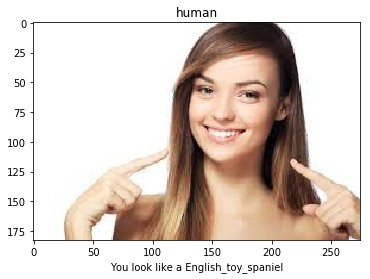

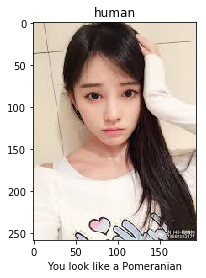

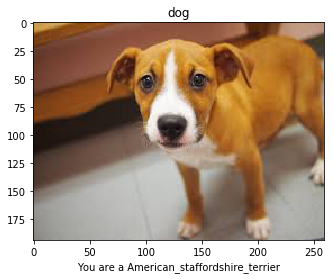

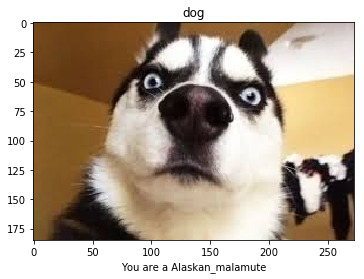

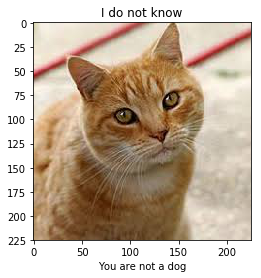

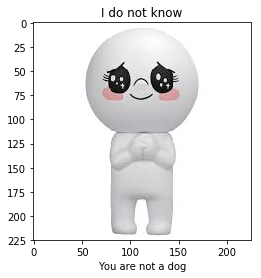

In [41]:
my_files = np.array(glob("test_img/*"))
for temp in my_files:
    img_predict_breed(temp)